In [11]:
from transformers import BigBirdPegasusForConditionalGeneration, AutoTokenizer, AutoModelForSeq2SeqLM
import sys
import pickle
from rouge_score import rouge_scorer
from rouge_score import scoring
import random
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

In [3]:
# imports

# delete research article 
class ResearchArticle(object):
    def __init__(self, article_id, abstract_text, article_text):
        """
          'article_id': str,
          'abstract_text': List[str],
          'article_text': List[str],
        """
        self.article_id = article_id
        self.abstract_text = abstract_text
        self.article_text = article_text


def load_data(path):
    """
    path - path where data is stored

    data - returns data as ResearchArticle objects

    """
    with open(path, 'rb') as f:
        data = pickle.load(f, encoding='bytes')
    return data

def shuffle_and_sample(data):
    random.seed(42)
    random.shuffle(data)
    return data[:600]


def to_paragraph(text):
    """
    converts text comprised of lists of sentances to a single to_paragraph

    text - list of multiple string sentances

    continuous_text - single continuous text string
    """
    continuous_text = ''
    for line in text:
        continuous_text += line
    return continuous_text

def get_scores(hypothesis, reference):
    """
    if hypothesis and or reference is converted to summary or not, this returns
    the rouge score of the two

    hypothesis - list of sentances or single paragraph

    reference - list of sentances or single paragraph

    score - rouge scores Todo:specify output
    """
    if len(hypothesis) !=1:
        hypothesis_abstract = to_paragraph(hypothesis)
    if len(reference) != 1:
        reference_abstract = to_paragraph(reference)
    rouge = Rouge()
    score = rouge.get_scores(hypothesis_abstract, reference_abstract)
    return score

### Load Data

In [4]:
with open('../data/mini_val_set_json.txt') as json_file:
    mini_val = json.load(json_file)
mini_val = mini_val['data']

In [ ]:
summaries_df = pd.DataFrame(columns=['reference', 'prediction'])
results = {}
# initialize tokenizer, model, and scorer
tokenizer = AutoTokenizer.from_pretrained("google/bigbird-pegasus-large-pubmed")
model = BigBirdPegasusForConditionalGeneration.from_pretrained("google/bigbird-pegasus-large-pubmed")
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeLsum"], use_stemmer=True)
aggregator = scoring.BootstrapAggregator()
for i in range(len(mini_val)):
    input = tokenizer(mini_val[i]['article_text'], is_split_into_words=True, return_tensors='pt', max_length=4096, truncation=True)
    prediction = model.generate(**input)
    prediction = tokenizer.batch_decode(prediction)
    score = scorer.score(to_paragraph(mini_val[i]['abstract_text']), prediction[0])
    aggregator.add_scores(score)
    ag_score = aggregator.aggregate()
    results[mini_val[i]['article_id']] = score
    addition = pd.DataFrame([[to_paragraph(mini_val[i]['abstract_text']), prediction[0]]],columns=['reference', 'prediction'])
    summaries_df = summaries_df.append(addition, ignore_index=True)
    if i % 10 == 0:
        print(f'Processed {i} documents')
final_ag_score = ag_score
print('Completed document evaluation')
print(final_ag_score)
with open("trucated_doc_results.txt", 'w') as outfile:
    json.dump(results, outfile)
summaries_df.to_csv('bigbird_baseline_summaries.csv', index=False)

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


Processed 0 documents
Processed 10 documents
Processed 20 documents
Processed 30 documents
Processed 40 documents
Processed 50 documents
Processed 60 documents
Processed 70 documents
Processed 80 documents
Processed 90 documents
Processed 100 documents
Processed 110 documents
Processed 120 documents
Processed 130 documents
Processed 140 documents
Processed 150 documents
Processed 160 documents
Processed 170 documents


Attention type 'block_sparse' is not possible if sequence_length: 458 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3. Changing attention type to 'original_full'...


Processed 180 documents
Processed 190 documents
Processed 200 documents
Processed 210 documents
Processed 220 documents
Processed 230 documents
Processed 240 documents
Processed 250 documents
Processed 260 documents
Processed 270 documents
Processed 280 documents
Processed 290 documents
Processed 300 documents
Processed 310 documents
Processed 320 documents
Processed 330 documents
Processed 340 documents


Analize results

In [6]:
# gedata/rate token lenghts for each document
# read in validation data
with open('../data/mini_val_set_json.txt') as json_file:
    mini_val = json.load(json_file)
mini_val = mini_val['data']
# test to evaluate if these are the correct indexes (should print 600)
# read indexes
with open('../data/mini_val_indexes.txt') as f:
    indexes = set(f.read().split('\t'))
# compare indexes
correct = 0
for i in mini_val:
    if i['article_id'] in indexes:
        correct += 1
print(f'{correct} correct indexes.')
token_lengths = {}
#instantiate tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/bigbird-pegasus-large-pubmed")
for i in mini_val:
    token_lengths[i['article_id']] = len(tokenizer(i['article_text'],is_split_into_words=True, return_tensors='pt', truncation=False)[0])
    

600 correct indexes.


Token indices sequence length is longer than the specified maximum sequence length for this model (6506 > 4096). Running this sequence through the model will result in indexing errors


In [7]:
with open('../results/baseline_results/bigbird_baseline_results.txt') as json_file:
    results = json.load(json_file)
    
df = pd.DataFrame.from_dict(results, orient='index') # import data into pandas

# UDFs to unpack values
def unpack_f1(line, index=2):
    return line[index]
def unpack_precision(line, index=0):
    return line[index]
def unpack_recall(line, index=1):
    return line[index]
# UDF to get length
def get_length(article_id, token_lengths=token_lengths):
    return token_lengths[article_id]


# unpack values into individual columns
df['rouge_1_f1'] = df.rouge1.apply(unpack_f1)
df['rouge_1_recall'] = df.rouge1.apply(unpack_recall)
df['rouge_1_precision'] = df.rouge1.apply(unpack_precision)
df['rouge_2_f1'] = df.rouge2.apply(unpack_f1)
df['rouge_2_recall'] = df.rouge2.apply(unpack_recall)
df['rouge_2_precision'] = df.rouge2.apply(unpack_precision)
df['rouge_lsum_f1'] = df.rougeLsum.apply(unpack_f1)
df['rouge_lsum_recall'] = df.rougeLsum.apply(unpack_recall)
df['rouge_lsum_precision'] = df.rougeLsum.apply(unpack_precision)

# reset index and rename article id field
df.reset_index(inplace=True)
df.rename({'index':'article_id'},axis=1, inplace=True)
df.article_id = [i['article_id'] for i in mini_val]
# add length
df['length'] = df.article_id.apply(get_length)
df.head()

,article_id,rouge1,rouge2,rougeLsum,rouge_1_f1,rouge_1_recall,rouge_1_precision,rouge_2_f1,rouge_2_recall,rouge_2_precision,rouge_lsum_f1,rouge_lsum_recall,rouge_lsum_precision,length
0,PMC4852153,"[0.4385026737967914, 0.43157894736842106, 0.43...","[0.1774193548387097, 0.1746031746031746, 0.176]","[0.24064171122994651, 0.23684210526315788, 0.2...",0.435013,0.431579,0.438503,0.176000,0.174603,0.177419,0.238727,0.236842,0.240642,4095
1,PMC3662463,"[0.5706521739130435, 0.481651376146789, 0.5223...","[0.29508196721311475, 0.2488479262672811, 0.26...","[0.3858695652173913, 0.3256880733944954, 0.353...",0.522388,0.481651,0.570652,0.270000,0.248848,0.295082,0.353234,0.325688,0.385870,6506
2,PMC3469893,"[0.654320987654321, 0.3322884012539185, 0.4407...","[0.20496894409937888, 0.10377358490566038, 0.1...","[0.35185185185185186, 0.1786833855799373, 0.23...",0.440748,0.332288,0.654321,0.137787,0.103774,0.204969,0.237006,0.178683,0.351852,4611
3,PMC3485825,"[0.4329896907216495, 0.358974358974359, 0.3925...","[0.15625, 0.12931034482758622, 0.1415094339622...","[0.23711340206185566, 0.19658119658119658, 0.2...",0.392523,0.358974,0.432990,0.141509,0.129310,0.156250,0.214953,0.196581,0.237113,1637
4,PMC3481817,"[0.44565217391304346, 0.23295454545454544, 0.3...","[0.08791208791208792, 0.045714285714285714, 0....","[0.20652173913043478, 0.10795454545454546, 0.1...",0.305970,0.232955,0.445652,0.060150,0.045714,0.087912,0.141791,0.107955,0.206522,1700


m1: -4.920983024253762e-07, m2: -3.994596111643308e-06, m3: -2.00962896655009e-06
m4: -3.814223344574223e-06, m5: -4.446429306311938e-06, m6: -3.8966347412232785e-06
m7: -1.6683801488497538e-06, m8: -3.912931742398249e-06, m9: -2.6285248684053657e-06


Rouge 1 f1 Mean: 0.42162974590540603
Rouge 2 f1 Mean: 0.17477887790152452
Rouge lsum f1 Mean: 0.26136778556820206


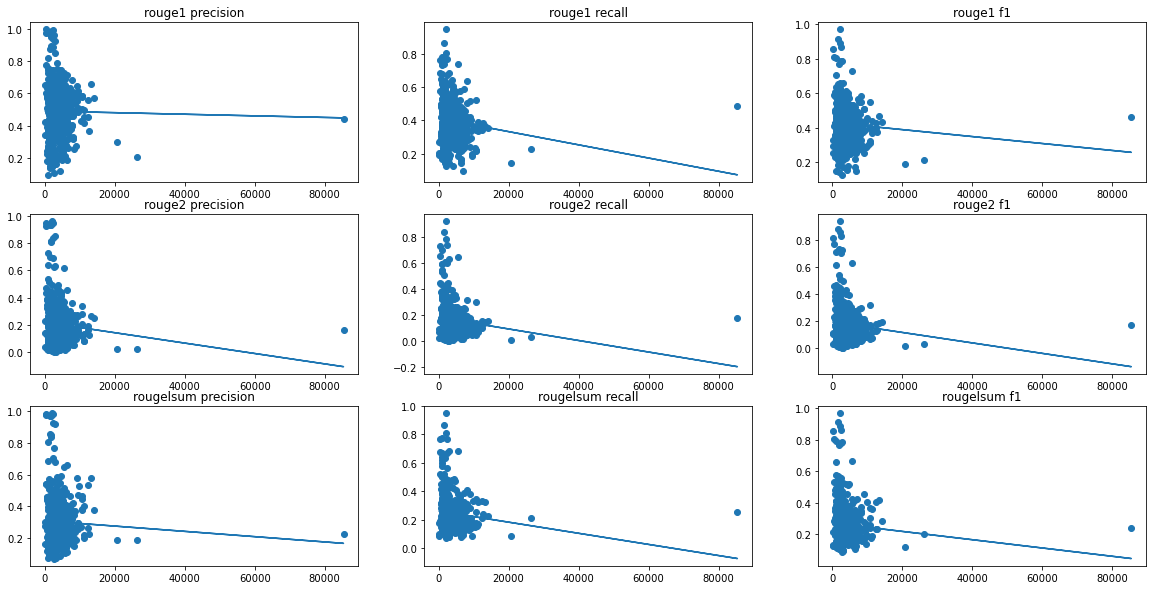

In [12]:
#df = df[df['length'] >= 4096]
fig, axs = plt.subplots(3,3, figsize = (20,10))
axs[0,0].set_title('rouge1 precision')
axs[0,0].scatter(df.length, df.rouge_1_precision)
m1, b1 = np.polyfit(df.length, df.rouge_1_precision, 1)
axs[0,0].plot(df.length, m1*df.length + b1)
#rouge 1
axs[0,1].set_title('rouge1 recall')
axs[0,1].scatter(df.length, df.rouge_1_recall)
m2, b2 = np.polyfit(df.length, df.rouge_1_recall, 1)
axs[0,1].plot(df.length, m2*df.length + b2)

axs[0,2].set_title('rouge1 f1')
axs[0,2].scatter(df.length, df.rouge_1_f1)
m3, b3 = np.polyfit(df.length, df.rouge_1_f1, 1)
axs[0,2].plot(df.length, m3*df.length + b3)


# rouge 2
axs[1,0].set_title('rouge2 precision')
axs[1,0].scatter(df.length, df.rouge_2_precision)
m4, b4 = np.polyfit(df.length, df.rouge_2_precision, 1)
axs[1,0].plot(df.length, m4*df.length + b4)

axs[1,1].set_title('rouge2 recall')
axs[1,1].scatter(df.length, df.rouge_2_recall)
m5, b5 = np.polyfit(df.length, df.rouge_2_recall, 1)
axs[1,1].plot(df.length, m5*df.length + b5)

axs[1,2].set_title('rouge2 f1')
axs[1,2].scatter(df.length, df.rouge_2_f1)
m6, b6 = np.polyfit(df.length, df.rouge_2_f1, 1)
axs[1,2].plot(df.length, m6*df.length + b6)


# rouge lsum
axs[2,0].set_title('rougelsum precision')
axs[2,0].scatter(df.length, df.rouge_lsum_precision)
m7, b7 = np.polyfit(df.length, df.rouge_lsum_precision, 1)
axs[2,0].plot(df.length, m7*df.length + b7)

axs[2,1].set_title('rougelsum recall')
axs[2,1].scatter(df.length, df.rouge_lsum_recall)
m8, b8 = np.polyfit(df.length, df.rouge_lsum_recall, 1)
axs[2,1].plot(df.length, m8*df.length + b8)

axs[2,2].set_title('rougelsum f1')
axs[2,2].scatter(df.length, df.rouge_lsum_f1)
m9, b9 = np.polyfit(df.length, df.rouge_lsum_f1, 1)
axs[2,2].plot(df.length, m9*df.length + b9)

print(f'm1: {m1}, m2: {m2}, m3: {m3}')
print(f'm4: {m4}, m5: {m5}, m6: {m6}')
print(f'm7: {m7}, m8: {m8}, m9: {m9}')
print('\n')
print(f'Rouge 1 f1 Mean: {df.rouge_1_f1.mean()}')
print(f'Rouge 2 f1 Mean: {df.rouge_2_f1.mean()}')
print(f'Rouge lsum f1 Mean: {df.rouge_lsum_f1.mean()}')